In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from multiprocessing import Pool, shared_memory

In [2]:
from scipy.stats import erlang
import math
def create_exp_dist(lamb):
    def exp_dist(x):
        return lamb*np.exp(-lamb*x)
    return exp_dist

def create_Erlang_dist(lamb, k):
    def Erlang_dist(x):
        return erlang.pdf(x, k, scale=1/lamb)
#         ret = np.exp(-lamb*x)*lamb
#         for i in range(1, k):
#             ret = ret*(x*lamb)/i
#         return ret#np.exp(-lamb*x)*((x*lamb)**k)/x#(x*math.factorial(k-1))
    return Erlang_dist
    
def alpha(c, dist_func=None):
    assert dist_func != None
    return integrate.quad(lambda x: (1-(x/c))*dist_func(x),
                          0, 
                          c)[0]

In [3]:
import math
def psn3(c, lamb, k):
        
    def second_int(r):
        return ((np.pi/2) 
                - (r/c)*np.sqrt(1- (c/r)**2)
                + (r/(3*c))*np.power(1- (c/r)**2, 3/2)
                - np.arcsin(c/r))
    def partial_E():
        def func(r):
            ret = second_int(r) * lamb  * np.exp(-lamb*r)
            for i in range(1, k):
                ret = ret*lamb*r/i
            return ret
            #return second_int(r) * (lamb**k) * (r**(k-1)) * np.exp(-lamb*r)/math.factorial(k-1)
        return integrate.quad(func,
                              c, np.inf)[0]
    return (k/(3*lamb*np.pi*c)) + (1/(np.pi))*partial_E()

In [4]:
repeats = 5
res5 = np.load("P_I_P_S_expo_no_scaling.npy")
ns = np.array([4, 8, 16, 32, 64, 128, 256, 512])
c = 1
lambs = np.array([ c*10, c*50,  1000*c])

stats_super_stable = np.zeros((ns.shape[0], lambs.shape[0], repeats))
mean_super_stable = np.zeros((ns.shape[0], lambs.shape[0]))
std_super_stable = np.zeros((ns.shape[0], lambs.shape[0]))
stats_inc_stable = np.zeros((ns.shape[0], lambs.shape[0], repeats))
mean_inc_super_stable = np.zeros((ns.shape[0], lambs.shape[0]))
std_inc_super_stable = np.zeros((ns.shape[0], lambs.shape[0]))
for j,n in enumerate(ns):
    for k,lamb in enumerate(lambs):
        for t in range(repeats):
            index = j*lambs.shape[0]*repeats + k*repeats + t
            stats_super_stable[j, k, t ] =   res5[index][1]
            stats_inc_stable[j, k, t ] =   res5[index][2]
            
mean_super_stable = np.mean(stats_super_stable, axis=2)
std_super_stable = np.std(stats_super_stable, axis=2)
mean_inc_stable = np.mean(stats_inc_stable, axis=2)
std_inc_stable = np.std(stats_inc_stable, axis=2)


dists = np.array([[create_Erlang_dist(lamb, n-1)
                  for n in ns]
                  for lamb in lambs ])
alphas = np.array([[alpha(c, dist) 
                    for dist in dists[i, :]]
                    for i in range(dists.shape[0])
                  ])
alphas_n = np.array([[alpha**n
                      for alpha, n in zip(alphas[i, :], ns)]
                      for i in range(alphas.shape[0])
                  ])

gamma = 0.0005
gammas = np.array([[ psn3(c, lamb*np.sqrt(n), n) for n in ns] for lamb in lambs])


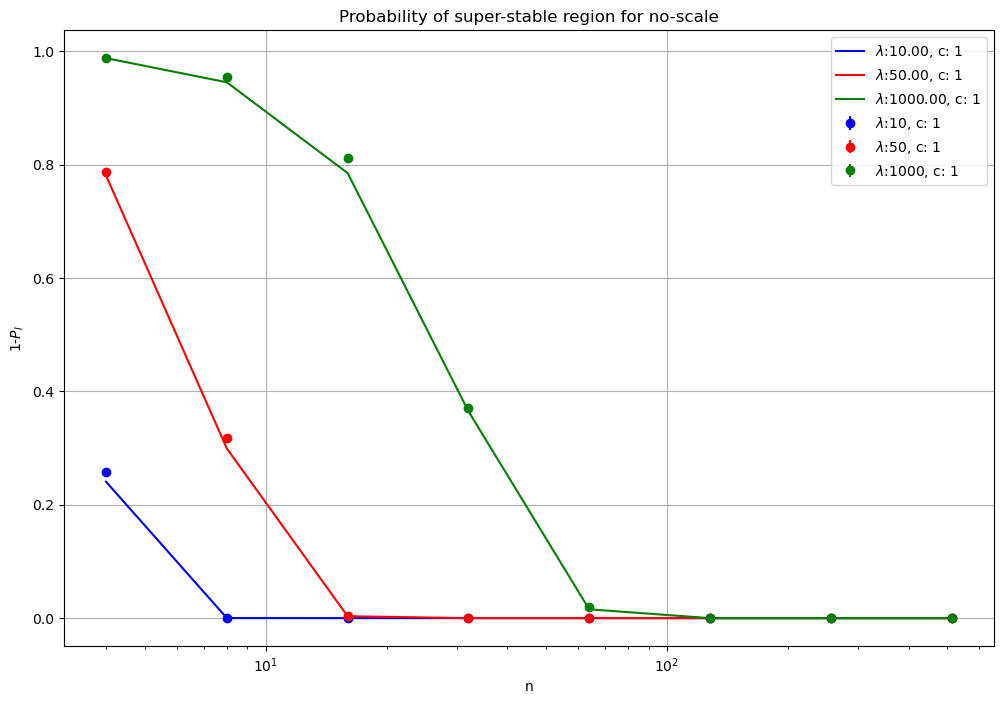

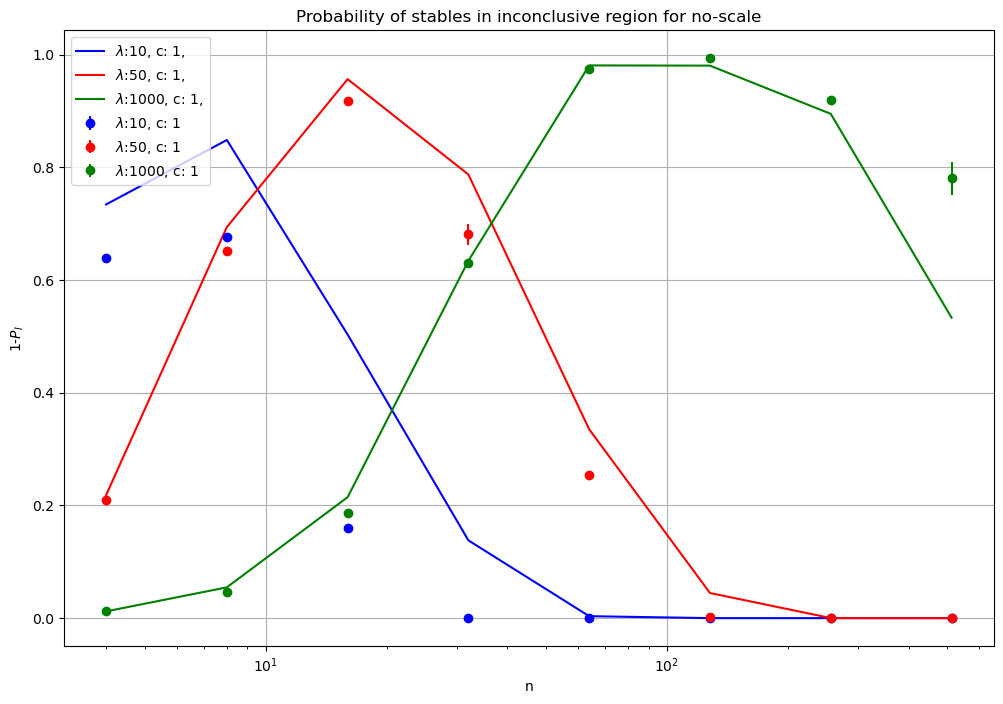

In [5]:
plt.figure(figsize=(12,8))
colors = ['blue', 'red', 'green']
for k,lamb in enumerate(lambs):
    plt.plot(ns,
             alphas_n[k, :], 
             '-',
             c=colors[k%3],
             label=r"$\lambda$:" f"{lamb:2.2f}, c:{c:2.0f}")
    
    plt.errorbar(ns, mean_super_stable[:, k],
                 yerr=std_super_stable[:, k], 
                 fmt="o",
                 c=colors[k%3],
                 label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}")
    

plt.xlabel("n");plt.ylabel(r"1-$P_I$");plt.title(r"Probability of super-stable region for no-scale")    
plt.legend();plt.grid();plt.xscale('log');plt.show()

plt.figure(figsize=(12,8))

for k,lamb in enumerate(lambs):
    
    plt.errorbar(ns, mean_inc_stable[:, k],
                 yerr=std_inc_stable[:, k],
                 fmt="o",
                 c=colors[k%3],
                 label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}")

    plt.plot(ns,
             (1 - gammas[k, :]*(1-alphas[k, :]))**ns - alphas[k, :]**ns, 
             '-',
             c=colors[k%3],
             label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}, " )
    
#     plt.plot(ns,
#              (1 - gammas[k, 0]*(1-alphas[k, :]))**ns - alphas[k, :]**ns, '-',
#              label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}, " )

plt.xlabel("n");plt.ylabel(r"1-$P_I$");plt.title(r"Probability of stables in inconclusive region for no-scale")    
plt.legend();plt.grid();plt.xscale('log');plt.show()
    

In [65]:
from scipy.stats import norm
import math
def create_normal_dist(mean, std):
    def normal_dist(x):
        return np.exp(-((x-mean)**2)/(2*std*std))/np.sqrt(2*np.pi*std*std)
        #return norm.pdf(x, loc=mean, scale=std)
    return normal_dist

def create_folded_normal_dist(mean, std):
    def folded_normal_dist(x):
        return (np.sqrt(2/(np.pi*std*std))*np.exp(-(x**2+mean**2)/(2*std*std))
                *np.cosh(x*mean/(std*std)))
        #return norm.pdf(x, loc=mean, scale=std)
    return folded_normal_dist

def create_zero_mean_k_folded_normal_dist(std, k):
    def zero_mean_k_folded_normal_dist(x):
        return (np.sqrt(2*k/(np.pi*std*std))*np.exp(-x*x/(2*k*std*std))
                *(np.power(2*norm.cdf(x/(np.sqrt(k)*std)) - 1,k-1)))
        #return norm.pdf(x, loc=mean, scale=std)
    return zero_mean_k_folded_normal_dist


import math
def psn4(c, std, k):
        
    nor = create_zero_mean_k_folded_normal_dist(std, k)
    def second_int(r):
        return ((np.pi/2) 
                - (r/c)*np.sqrt(1- (c/r)**2)
                + (r/(3*c))*np.power(1- (c/r)**2, 3/2)
                - np.arcsin(c/r))
    def partial_E():        
        return integrate.quad(lambda r: second_int(r)*nor(r),
                              c, np.inf)[0]
    
    def mean():
        return integrate.quad(lambda r: r*nor(r),
                              0, np.inf)[0]
    return (2*mean()/(3*np.pi*c)) + (1/(np.pi))*partial_E()

In [66]:
k=4
dist = create_zero_mean_k_folded_normal_dist(1, k)
aaa = np.zeros(k+1)
for i in range(100000):
    m = np.random.normal(0,1, ((k+1, k+1)))
    aaa += np.sum(np.abs(m - np.diag(np.diag(m))), axis=1)#/k
    
    
np.mean(aaa/100000),np.std(aaa/100000), integrate.quad(lambda r: r*dist(r),
                              0, np.inf)[0], integrate.quad(lambda r: dist(r),
                              0, np.inf)[0]

(3.1934947176753394, 0.0022367461790109185, 2.929455962917275, 1.0)

In [46]:
np.sum(np.abs(m - np.diag(np.diag(m))), axis=1)

array([2.65616977, 2.08915219, 3.01661921, 2.37164087])

In [41]:
repeats = 5
res6 = np.load("P_I_P_S_normal_no_scaling.npy")
ns = np.array([4, 8, 16, 32, 64, 128, 256, 512])
c = 1
stds = np.array([ 0.01, 0.1, 1])

stats_super_stable_normal = np.zeros((ns.shape[0], stds.shape[0], repeats))
mean_super_stable_normal = np.zeros((ns.shape[0], stds.shape[0]))
std_super_stable_normal = np.zeros((ns.shape[0], stds.shape[0]))
stats_inc_stable_normal = np.zeros((ns.shape[0], stds.shape[0], repeats))
mean_inc_super_stable_normal = np.zeros((ns.shape[0], stds.shape[0]))
std_inc_super_stable_normal = np.zeros((ns.shape[0], stds.shape[0]))
for j,n in enumerate(ns):
    for k,std in enumerate(stds):
        for t in range(repeats):
            index = j*stds.shape[0]*repeats + k*repeats + t
            stats_super_stable_normal[j, k, t ] =   res6[index][1]
            stats_inc_stable_normal[j, k, t ] =   res6[index][2]
            
mean_super_stable_normal = np.mean(stats_super_stable_normal, axis=2)
std_super_stable_normal = np.std(stats_super_stable_normal, axis=2)
mean_inc_stable_normal = np.mean(stats_inc_stable_normal, axis=2)
std_inc_stable_normal = np.std(stats_inc_stable_normal, axis=2)



dists = np.array([[create_zero_mean_k_folded_normal_dist(std, n-1)
                   for n in  ns]
                  for std in stds])
alphas = np.array([[alpha(c, dist) 
                    for dist in dists[i, :]]
                    for i in range(dists.shape[0])
                  ])
alphas_n = np.array([[alpha**n
                      for alpha, n in zip(alphas[i, :], ns)]
                      for i in range(alphas.shape[0])
                  ])


gammas = np.array([[psn4(c, std , n) for n in ns] for std in stds] )

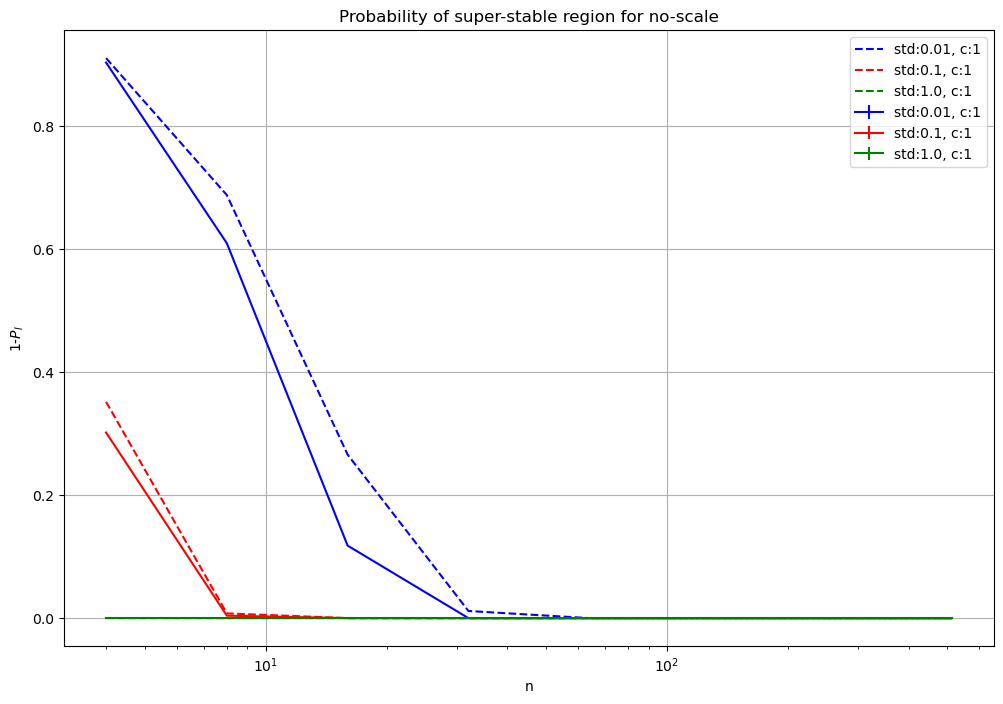

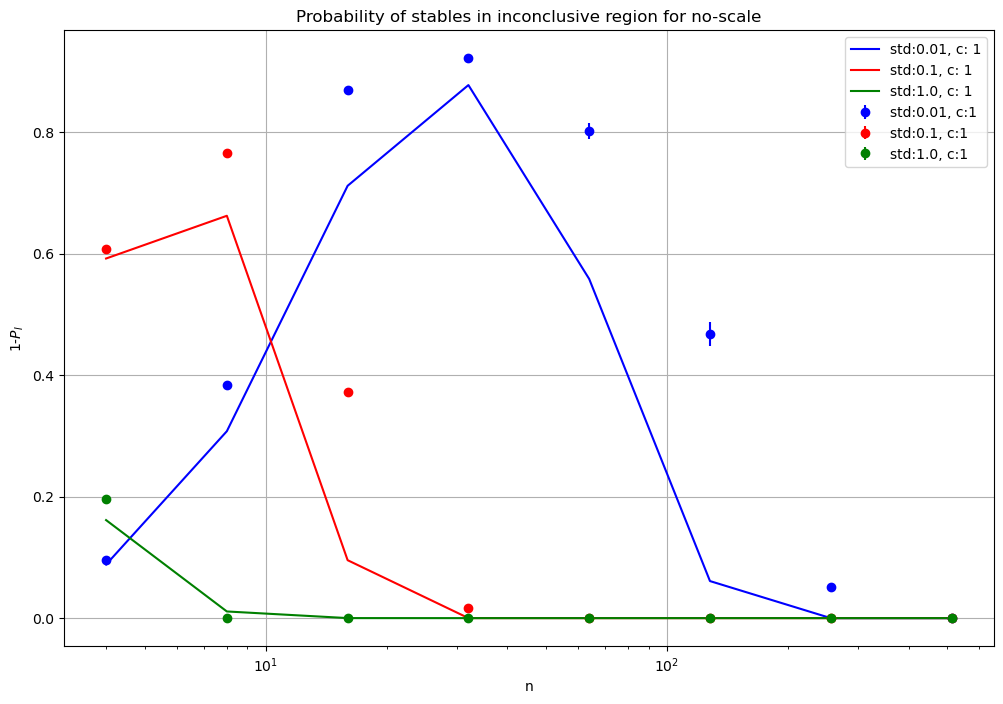

In [42]:
plt.figure(figsize=(12,8))
colors = ['blue', 'red', 'green']
for l,std in enumerate(stds):
    plt.plot(ns,
             alphas_n[l, :], 
             '--',
             c=colors[l%3],
             label=f"std:{std}, c:{c}")
    
    plt.errorbar(ns, mean_super_stable_normal[:, l],
                 yerr=std_super_stable_normal[:, l], 
                 fmt="-",
                 c=colors[l%3],
                 label=f"std:{std}, c:{c}")
    

plt.xlabel("n");plt.ylabel(r"1-$P_I$");plt.title(r"Probability of super-stable region for no-scale")    
plt.legend();plt.grid();plt.xscale('log');plt.show()

plt.figure(figsize=(12,8))

for l,std in enumerate(stds):
    plt.plot(ns,
             (1 - gammas[ l, :]*(1-alphas[l]))**ns - alphas[l]**ns, 
             '-',
             c=colors[l%3],
             label=f"std:{std}, c:{c:2.0f}" )

    plt.errorbar(ns, mean_inc_stable_normal[:, l],
                 yerr=std_inc_stable_normal[:, l],
                 fmt="o",
                 c=colors[l%3],
                 label=f"std:{std}, c:{c}")


plt.xlabel("n");plt.ylabel(r"1-$P_I$");plt.title(r"Probability of stables in inconclusive region for no-scale")    
plt.legend();plt.grid();plt.xscale('log');plt.show()
    

In [15]:
repeats = 5
ns = np.array([4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096])
c = 10
lambs = np.array([ c/2, c, 2*c])
res4 = np.load("P_I_P_S_1.npy")
stats_super_stable = np.zeros((ns.shape[0], lambs.shape[0], repeats))
mean_super_stable = np.zeros((ns.shape[0], lambs.shape[0]))
std_super_stable = np.zeros((ns.shape[0], lambs.shape[0]))
stats_inc_stable = np.zeros((ns.shape[0], lambs.shape[0], repeats))
mean_inc_super_stable = np.zeros((ns.shape[0], lambs.shape[0]))
std_inc_super_stable = np.zeros((ns.shape[0], lambs.shape[0]))
for j,n in enumerate(ns):
    for k,lamb in enumerate(lambs):
        for t in range(repeats):
            index = j*lambs.shape[0]*repeats + k*repeats + t
            stats_super_stable[j, k, t ] =   res4[index][1]
            stats_inc_stable[j, k, t ] =   res4[index][2]
            
mean_super_stable = np.mean(stats_super_stable, axis=2)
std_super_stable = np.std(stats_super_stable, axis=2)
mean_inc_stable = np.mean(stats_inc_stable, axis=2)
std_inc_stable = np.std(stats_inc_stable, axis=2)


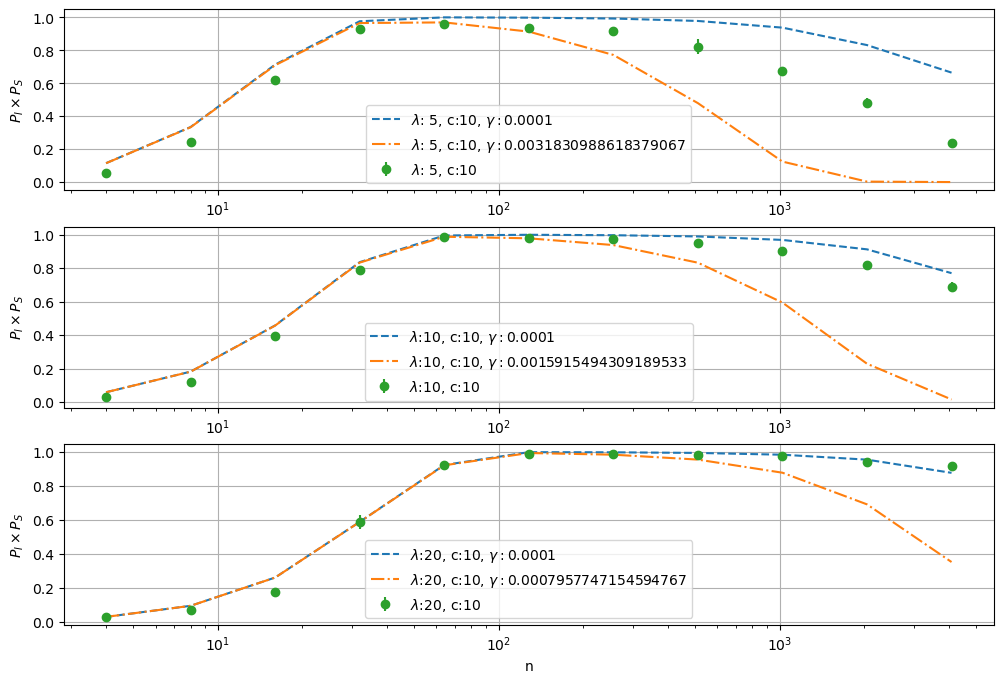

In [19]:
dists = np.array([[create_Erlang_dist(lamb*np.sqrt(n), n-1)
                  for n in ns]
                  for lamb in lambs ])
alphas = np.array([[alpha(c, dist) 
                    for dist in dists[i, :]]
                    for i in range(dists.shape[0])
                  ])
alphas_n = np.array([[alpha**n
                      for alpha, n in zip(alphas[i, :], ns)]
                      for i in range(alphas.shape[0])
                  ])

gamma = 0.0001
gammas_2 = np.array([[ psn3(c, lamb*np.sqrt(n), n-1) for n in ns] for lamb in lambs])
plt.figure(figsize=(12,8))
plt.title("Probability of stable matricies in inconclusive \n" r"region for scaled $\lambda \sqrt{n}$")    
for k,lamb in enumerate(lambs): 
    if k == 0:
        plt.subplot(311)
    elif k == 1:
        plt.subplot(312)
    else:
        plt.subplot(313)
    plt.plot(ns,
             (1 - gamma*(1-alphas[k, :]))**ns - alphas[k, :]**ns, '--',
             label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}, " r"$\gamma:$" f"{gamma}")
    
    plt.plot(ns,
             (1 - gammas_2[k, 0]*(1-alphas[k, :]))**ns - alphas[k, :]**ns, '-.',
             label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}, " r"$\gamma:$" f"{gammas_2[k, 0]}")
    
    plt.errorbar(ns, mean_inc_stable[:, k],
                 yerr=std_inc_stable[:, k],
                 fmt="o",
                 label=r"$\lambda$:" f"{lamb:2.0f}, c:{c:2.0f}")
    plt.legend();plt.grid();plt.xscale('log');plt.ylabel(r"$P_I \times P_S$");

plt.xlabel("n");
plt.show()

